# 概要

**业务场景**

Porto Seguro是巴西最大的汽车与住房保险公司之一，根据汽车保单持有人的数据建立机器学习模型，分析该持有人是否会在次年提出索赔。数据已进行脱敏

**数据集**

porto seguro safe driver prediction（kaggle 2017年比赛）

**模型选用**

1. GBDT+LR模型进行预测
2. 样本平衡SMOTE

**预测效果**

1. 召回得分：100%
2. 准确率：98%

In [1]:
# ! pip install imblearn

In [2]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'google.colab'

In [45]:
# drive.mount('/content/drive')
# os.chdir("/content/drive/My Drive/Colab Notebooks/porto-seguro-safe-driver-prediction")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 数据探索

In [46]:
data = pd.read_csv('train.csv')
data.head(5).append(data.tail(5))

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [48]:
test = pd.read_csv('./test.csv')
test.head(5).append(test.tail(5))

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1
892811,1488022,0,1,6,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0.5,0.3,1.048809,0,1,-1,8,0,14,0,1,0,1,18,2,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0
892812,1488023,5,3,5,1,0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.7,1.0,1.246495,8,1,-1,0,0,10,1,0,0,1,83,2,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0
892813,1488024,0,1,5,0,0,1,0,0,0,0,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,11,1,-1,0,-1,11,1,0,1,1,17,2,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0
892814,1488025,6,1,5,1,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.6,0.6,0.920937,10,0,-1,0,1,10,1,1,0,1,28,3,0.387298,0.725125,0.378153,2.645751,0.1,0.1,0.3,1,1,9,2,10,1,8,1,1,2,7,1,1,0,0,0,0
892815,1488026,7,1,4,1,0,0,0,0,1,0,0,0,0,0,12,1,0,0,0.9,0.8,0.992157,9,1,1,0,0,4,1,1,2,1,48,1,0.316228,0.637175,0.296648,3.316625,0.4,0.4,0.2,3,4,7,2,8,4,15,5,2,2,7,0,1,1,1,0,0


In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892816 non-null  int64  
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892816 non-null  int64  
 5   ps_ind_05_cat   892816 non-null  int64  
 6   ps_ind_06_bin   892816 non-null  int64  
 7   ps_ind_07_bin   892816 non-null  int64  
 8   ps_ind_08_bin   892816 non-null  int64  
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-null  int64  
 17  ps_ind_17_

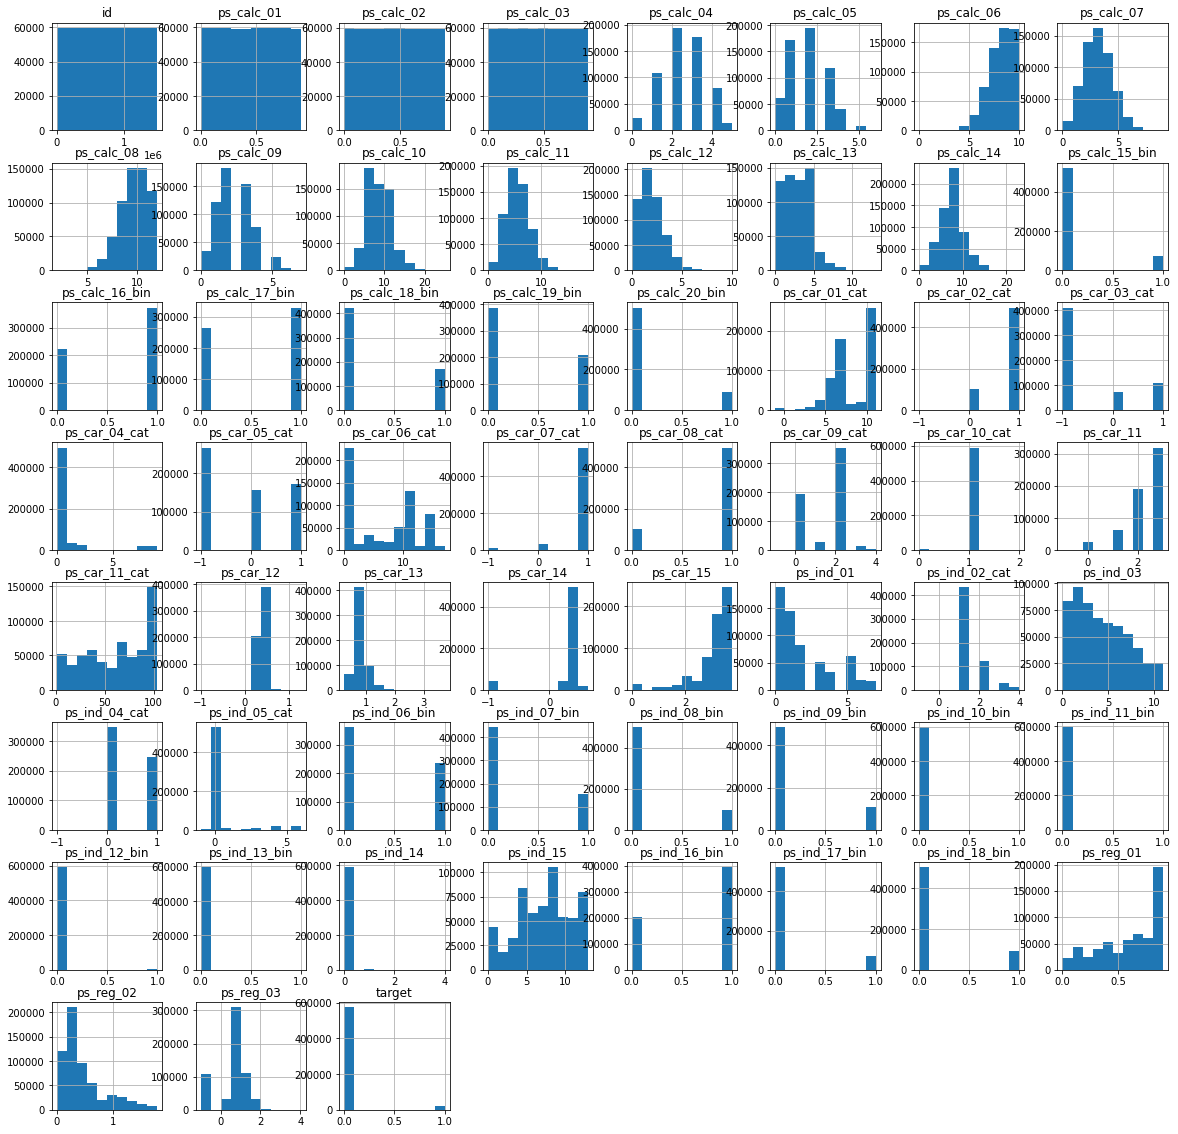

In [50]:
data.hist(figsize=(20,20))
plt.show()

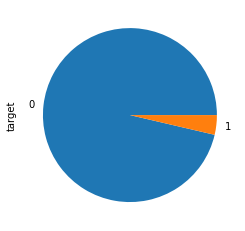

In [51]:
data['target'].value_counts().plot.pie()
plt.show()

In [52]:
# 基准最低准确率
data['target'].value_counts() / data['target'].value_counts().sum()

0    0.963552
1    0.036448
Name: target, dtype: float64

# 数据准备

In [53]:
# features与labels提取
features = data[[x for x in data.columns if x not in['target', 'id']]].values
labels = data['target'].values

# 非平衡数据处理
over_samples = SMOTE(k_neighbors=5)
features, labels = over_samples.fit_sample(features, labels)

# 标准化数据
std = StandardScaler()
featrues = std.fit_transform(features)

# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=1234)
X_train_lr, X_train_tree, y_train_lr, y_train_tree = train_test_split(X_train, y_train, test_size=0.5, random_state=1234)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# 模型训练

In [54]:
# 训练GBDT
gbtd = GradientBoostingClassifier()
gbtd.fit(X_train_tree, y_train_tree)
temp = gbtd.apply(X_train_tree)[:,:,0]

# 训练一个onehot
onehot = OneHotEncoder()
onehot.fit(temp)

# 获得LR的features
lr_features = onehot.transform(gbtd.apply(X_train_lr)[:,:,0])

# 训练LR
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(lr_features, y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# 模型评估

In [55]:
# 评估标准归一化信息熵
def normalized_cross_entropy(label, prob, avg_prob):
    if(label.shape != prob.shape):
        raise ValueError('label shape should be equal to the prob shape, '\
                         'label shape is {}, prob shape is {}'.format(label.shape, prob.shape))
    num = (-1.0/len(label))*sum(label*np.log(prob) + (1-label)*np.log(1-prob))
    den = -1.0*(avg_prob*np.log(avg_prob) + (1-avg_prob)*np.log(1-avg_prob))
    return num/den

In [56]:
# 模型预测
test_features = onehot.transform(gbtd.apply(X_test)[:,:,0])
pro = clf_lr.predict_proba(test_features)[:,1]
predict_labels = clf_lr.predict(test_features)
ave_pro = pro.mean()

# 模型评估
ne_score = normalized_cross_entropy(y_test, pro, ave_pro)
acc_score = accuracy_score(predict_labels, y_test)
rec_score = recall_score(predict_labels, y_test)

# 结果输出
print('NE score:{:.2f}%'.format(ne_score*100))
print('accuracy score:{:.2f}%'.format(acc_score*100))
print('recall score:{:.2f}%'.format(rec_score*100))

NE score:11.54%
accuracy score:98.10%
recall score:100.00%


# 测试集输出

In [57]:
features = test[[x for x in test.columns if x != 'id']].values
features = std.transform(features)
test_lr_features = onehot.transform(gbtd.apply(features)[:,:,0])
test['target'] = clf_lr.predict_proba(test_lr_features)[:,1]
test[['id', 'target']].to_csv('./test_predict.csv', index=False)